In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import colors
import cv2

In [2]:
def show_image_plt(img_rgb):
    plt.imshow(img_rgb)
    plt.show()

In [3]:
def resize_to_square(vegi_bgr):
    if vegi_bgr.shape[0] == 256 and vegi_bgr.shape[1] == 256:
        return vegi_bgr
    
    img_size = 256
    height, width = vegi_bgr.shape[:2]
    a1 = width / height
    a2 = height / width

    if (a1 > a2):
        r_img = cv2.resize(vegi_bgr, (round(img_size * a1), img_size), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[1]/6)
        resized_img = r_img[0:img_size, margin:(margin+img_size)]

    elif(a1 < a2):
        # if height greater than width
        r_img = cv2.resize(vegi_bgr, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        margin = int(r_img.shape[0]/6)
        resized_img = r_img[margin:(margin+img_size), 0:img_size]

    elif(a1 == a2):
        # if height and width are equal
        r_img = cv2.resize(vegi_bgr, (img_size, round(img_size * a2)), interpolation = cv2.INTER_AREA)
        resized_img = r_img[0:img_size, 0:img_size]

    if(resized_img.shape[0] != img_size or resized_img.shape[1] != img_size):
        resized_img = r_img[0:img_size, 0:img_size]

    return resized_img

In [4]:
def draw_contours(bgr_img, object_area):
    hsv = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    _, saturation, _ = cv2.split(hsv)

    blurred_sat = cv2.GaussianBlur(saturation, (3, 3), 0)

    # Compute the thresh dynamically from the mean() value. 
    thresh = blurred_sat.mean()
    std = blurred_sat.std()
    thresh_low = thresh - std
    thresh_high = thresh + std
    # The factors were simply selected by testing the algoritm. Another approach could be to calculate the mean with the standard deviation
    #thresh_low = 0.3 * thresh 
    #thresh_high = 2 * thresh
    
    # The next four lines control how good the bounding box will fit
    edges = cv2.Canny(blurred_sat, thresh_low, thresh_high)
    kernel = np.ones((4, 4), np.uint8) # creates 4x4 Identity matrix
    dilate = cv2.dilate(edges, kernel, iterations=4)
    erode = cv2.erode(dilate, kernel, iterations=4)

    contours, _ = cv2.findContours(erode, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
    
    bgr_img_copy = bgr_img.copy()
    # Flag makes sure that there is a maximum of 1 box in each image. Assumption, the bounding box for the vegi is always the biggest
    more_than_one_box = False
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area >= object_area:
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.intp(box)
            cv2.drawContours(bgr_img_copy, [box], 0, (0, 255, 0), 2)
            
            # Calculate Circularity
            perimeter = cv2.arcLength(contour, True)
            r_circle = perimeter / (2 * np.pi)
            A_circle = r_circle**2 * np.pi
            circularity = area / A_circle
            
            if i > 0:
                # There are more than 2 boxes in the image
                more_than_one_box = True
    
    rgb = cv2.cvtColor(bgr_img_copy, cv2.COLOR_BGR2RGB)
    return rgb, more_than_one_box, box, rect, area, circularity

def get_size_box(box):
    x0 = box[0][0]
    y0 = box[0][1]
    x1 = box[1][0]
    y1 = box[1][1]

    x2 = box[2][0]
    y2 = box[2][1]

    l0_1 = round(((x0 - x1)**2 + (y0 - y1)**2)**0.5, 2)
    l1_2 = round(((x1 - x2)**2 + (y1 - y2)**2)**0.5, 2)

    w = min(l0_1, l1_2)
    h = max(l0_1, l1_2)
    return h, w

def is_box_rotated(box):
    # If the box is not rotated then the top left corner should be the first element in box array
    x0, y0 = box[0][0], box[0][1]
    y1 = box[1][1]
    x3 = box[3][0]
    
    if y0 == y1 and x0 == x3:
        # box is not rotated
        return False
    # BOX IS ROTATED
    return True

def get_color(rgb_segment):
    cropped_vegi_2D = rgb_segment.reshape((-1,3))
    # convert to np.float32
    cropped_vegi_2D = np.float32(cropped_vegi_2D)

    # define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
    ret, label, center = cv2.kmeans(cropped_vegi_2D, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
   
    res = center[label.flatten()]
    res2 = res.reshape((rgb_segment.shape))
    
    #returns center in rgb format
    return center, ret, label

def mask_green(cropped_vegi_seg_rgb, lower_thresh=(30, 175, 25), higher_thresh=(100, 255, 255)):
    ## Convert to HSV
    cropped_vegi_seg_hsv = cv2.cvtColor(cropped_vegi_seg_rgb, cv2.COLOR_RGB2HSV)

    ## Mask of green (36,25,25) ~ (86, 255,255)
    # mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    mask = cv2.inRange(cropped_vegi_seg_hsv, lower_thresh, higher_thresh)
    
    ## Slice the green
    imask = mask>0
    green_rgb = np.zeros_like(cropped_vegi_seg_rgb, np.uint8)
    green_rgb[imask] = cropped_vegi_seg_rgb[imask]
    return green_rgb, imask

    #Image as BGR
def segment_img_2(cropped_vegi_bgr):
    #img must be BGR
    gray = cv2.cvtColor(cropped_vegi_bgr, cv2.COLOR_BGR2GRAY)

    _, thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV +cv2.THRESH_OTSU)
    return thresh

def color_from_segmented_binary(seg_bin, cropped_vegi_bgr):
    imask = seg_bin>0 #False / True array
    segment = np.zeros_like(cropped_vegi_bgr, np.uint8)
    segment[imask] = cropped_vegi_bgr[imask] #BGR

    segment_rgb = cv2.cvtColor(segment, cv2.COLOR_BGR2RGB) #RGB
    return segment_rgb

def count_green_pixels(binary_green_mask):
    #only count True boolean. These are my green pixels
    return binary_green_mask.sum()
    
def sift(img_bgr):
    gray_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)  # 256 x 256
    sift = cv2.SIFT_create(65536)
    kp, _ = sift.detectAndCompute(gray_img, None)
    #img = cv2.drawKeypoints(gray_img, kp, None, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    total = 0
    for key in kp:
        total += key.size
    mean = total / len(kp)
    return len(kp), mean

def crop_roi(img_bgr, box):
    left_point, top_point = np.min(box, axis=0) # left point = x coordiante, top point y coordinate could be from different points ! 
    right_point, bottom_point = np.max(box, axis=0)
   
    #new width and height
    if top_point < 0:
        top_point = 0

    if left_point < 0:
        left_point = 0

    if right_point > 256:
        right_point = 256

    if bottom_point > 256:
        bottom_point = 256

    h_new = bottom_point - top_point #rows
    w_new = right_point - left_point #cols

    new_top_left_point = np.array([left_point, top_point])

    new_crop = img_bgr[new_top_left_point[1]:new_top_left_point[1]+h_new, new_top_left_point[0]:new_top_left_point[0]+w_new]
    return new_crop

In [5]:
folders = ["Kartoffel", "Karotte", "Zwiebel", "Karotte_Trieb", "Zwiebel_Trieb", "Kartoffel_Trieb"]
#folders = ["Internet"]
paths_all_imgs = []
for fold in folders:
    for fname in os.listdir(f"G:/Meine Ablage/KI_Projekt/Trainingsdaten/{fold}"):
        paths_all_imgs.append(f"G:/Meine Ablage/KI_Projekt/Trainingsdaten/{fold}/{fname}")
        break
    break
paths_all_imgs[0]   

'G:/Meine Ablage/KI_Projekt/Trainingsdaten/Kartoffel/kartoffel_1.jpg'

In [49]:
#TODO adapt path to test images. It will be /Testdaten/foldername/...
paths_exam_testimages = []
for fname in os.listdir(f"G:/Meine Ablage/KI_Projekt/Pruefung/bilder"):
    if 'desktop.ini' in fname:
        continue
    paths_exam_testimages.append(f"G:/Meine Ablage/KI_Projekt/Pruefung/bilder/{fname}")
paths_exam_testimages

['G:/Meine Ablage/KI_Projekt/Pruefung/bilder/karotte_1.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/karotte_trieb_2.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/zwiebel_10.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/karotte_trieb_1.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/kartoffel_3.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/kartoffel_trieb_3.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/kartoffel_2.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/zwiebel_1.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/kartoffel_trieb_2.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/kartoffel_1.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/karotte_trieb_3.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/karotte_2.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/kartoffel_trieb_1.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/zwiebel_5.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefung/bilder/zwiebel_2.JPG',
 'G:/Meine Ablage/KI_Projekt/Pruefun

In [14]:
demo_img = ['G:/Meine Ablage/KI_Projekt/Trainingsdaten/Karotte_Trieb/karotte_trieb_209.jpg']

In [50]:
vegis_df = pd.DataFrame(columns=["Hight", "Width", "R", "G", "B", "green pixels",
                                 "green onion pixels", "ratio area", "circularity", 
                                 "keypoints", "mean keypoints", "Label", "Image"])
error_counter = 0
for i, path in enumerate(paths_exam_testimages):
    if 'desktop.ini' in path:
        continue

    ############################# Label the image ##################################
    vegi_label = path.split("/")[5].split("_")[0].title()
    #print(path)
    #print("label", vegi_label)
    vegi_BGR = cv2.imread(path) # As BGR
    vegi_sq_BGR_original = resize_to_square(vegi_BGR) # BGR

    try:
        ############################# Find Contours in image and draw a bounding box ##################################
        vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = draw_contours(vegi_sq_BGR_original, object_area=500)
        if more_than_one_box:
            box_size = 500
            while more_than_one_box:  # makes sure there is only one bounding box in the image
                box_size += 250
                vegi_with_box_rgb, more_than_one_box, box, rect, area, circularity = draw_contours(vegi_sq_BGR_original, box_size)

        ############################# Get pixel size from the bounding box (hight and width) ##################################
        h, w = [int(l) for l in get_size_box(box)]
        
        ############################# Calculate the Ratio Area Feature ##################################
        ratio_area_box = 0
        if h > 0 and w > 0:
            ratio_area_box = area / (h * w)

        ############################# Crop the including area from the bounding box (our ROI) ##################################
        if not is_box_rotated(box):
            #crop img directly
            # the top left corner should be the first element in box array
            cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w]
            
        else:
            cropped_vegi_BGR = crop_roi(vegi_sq_BGR_original, box) # BGR

        ############################# Do a binary segmentation only with the roi  ##################################
        cropped_segmented_binary_2 = segment_img_2(cropped_vegi_BGR)
        #print("Segmented BINARY From Cop NEW")
        #show_image_plt(cropped_segmented_binary_2)

        ############################# Apply the binary mask on the cropped image  ##################################
        cropped_vegi_segmented_rgb_2 = color_from_segmented_binary(cropped_segmented_binary_2, cropped_vegi_BGR) # center has rgb format
        #print("Segmented RGB")
        #show_image_plt(cropped_vegi_segmented_rgb_2)

        ##################### SIFT Algorithm - Calculates the mean keypoints and number of keypoints features #######################################
        num_kps, mean_kps = sift(vegi_sq_BGR_original)

        ############################# Apply a green mask on the image ##################################
        # Seems to be work best
        vegi_only_onion_tribe_rgb, onion_tribe_mask = mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(25, 40, 20), higher_thresh=(60, 160, 255))
        #print("ONLY GREEn TRIBE MASK")
        #show_image_plt(vegi_only_onion_tribe_rgb)
        vegi_only_tribe_rgb, tribe_mask = mask_green(cropped_vegi_segmented_rgb_2, lower_thresh=(27, 105, 20), higher_thresh=(120, 255, 255))
        ############################# Calculates the number of green pixels feature  ##################################
        amount_green_pixels_onion_tribe = count_green_pixels(onion_tribe_mask)
        amount_green_pixels_tribe = count_green_pixels(tribe_mask)
        ############################# Get the Color (R, G, B) Feature(s) with a kmean algorithm ##################################
        center, ret, label = get_color(cropped_vegi_segmented_rgb_2) #Center = RGB
        R, G, B = np.max(center, axis=0)

        #a = path.split(".")
        #b = a[0].split("_")

        label = path.split("/")[-1].split("_")
        v_label = label[0].title()
        #print(v_label)
        if len(label) == 3:
            v_label = "_".join(label[0:2]).title()
            #print("label final: ", v_label)

        #img_name = f"{vegi_label}_{b[-1]}"
        img_name = "aa"
        vegis_df.loc[len(vegis_df)] = [h, w, R, G, B, amount_green_pixels_tribe, amount_green_pixels_onion_tribe, ratio_area_box, circularity, num_kps, mean_kps, v_label, img_name]
        
        if i < 3:
            print(vegis_df)

    except Exception as e:
        print(f"########## Error: {e}")
        error_counter += 1
    

   Hight  Width    R   G   B  green pixels  green onion pixels  ratio area  \
0    265     58  100  53  28             1                   2    0.510703   

   circularity  keypoints  mean keypoints    Label Image  
0     0.125139         29        7.127002  Karotte    aa  
   Hight  Width    R   G   B  green pixels  green onion pixels  ratio area  \
0    265     58  100  53  28             1                   2    0.510703   
1    257     95   90  66  57           327                 600    0.363486   

   circularity  keypoints  mean keypoints          Label Image  
0     0.125139         29        7.127002        Karotte    aa  
1     0.090652         62        5.067550  Karotte_Trieb    aa  
   Hight  Width    R   G   B  green pixels  green onion pixels  ratio area  \
0    265     58  100  53  28             1                   2    0.510703   
1    257     95   90  66  57           327                 600    0.363486   
2    155    153   85  43  40             0                   

In [44]:
print("PATH", paths_exam_testimages[1])
#a = path.split(".")
c = paths_exam_testimages[0].split(".")[0]
print(c)
label = c.split("/")[-1].split("_")
v_label = label[0].title()
print(v_label)
if len(label) == 3:
    v_label = "_".join(label[0:2]).title()
    print("label final: ", v_label)

PATH G:/Meine Ablage/KI_Projekt/Pruefung/bilder/karotte_trieb_2.JPG
G:/Meine Ablage/KI_Projekt/Pruefung/bilder/karotte_1
Karotte


The resized image to 256x256 pixels


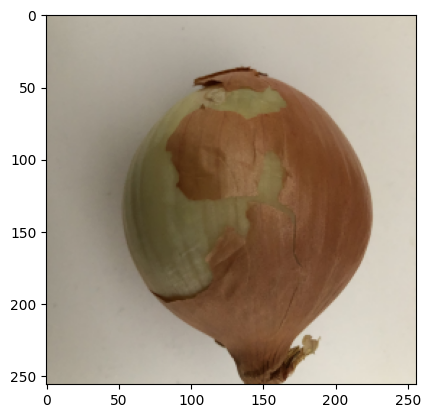

In [55]:
print("The resized image to 256x256 pixels")
show_image_plt(cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2RGB))

Shows the bounding box which was drawed around the founded contours


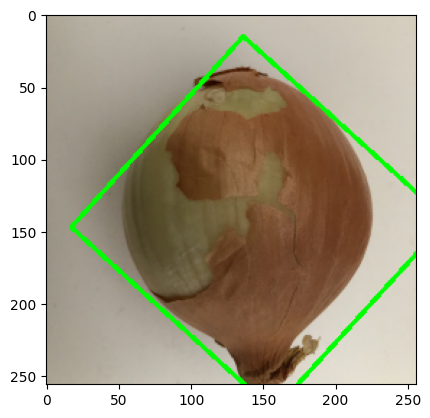

In [56]:
print("Shows the bounding box which was drawed around the founded contours")
show_image_plt(vegi_with_box_rgb)

Segmented Image after applying the binary mask


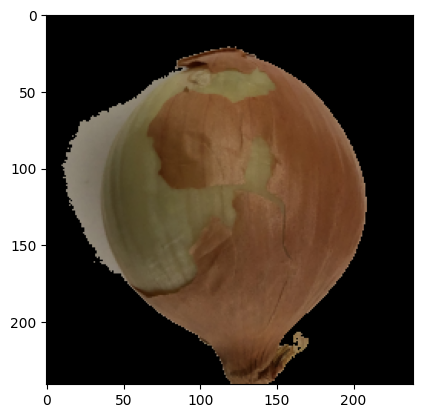

In [57]:
print("Segmented Image after applying the binary mask")
show_image_plt(cropped_vegi_segmented_rgb_2)

Shows the green color mask to get only the green pixels from the image


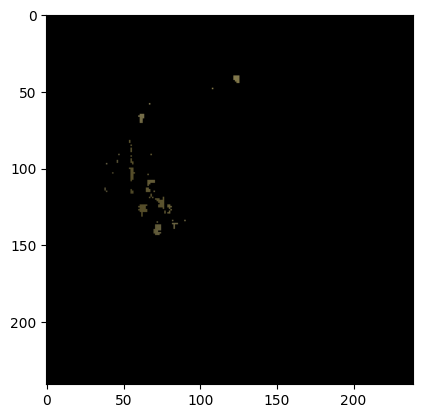

In [58]:
print("Shows the green color mask to get only the green pixels from the image")
show_image_plt(vegi_only_onion_tribe_rgb)

In [13]:
print("Finally the Dataframe with the extracted features from the input image")
print(vegis_df.head(2))

Finally the Dataframe with the extracted features from the input image
   Hight  Width   R   G   B  green pixels  green onion pixels  ratio area  \
0    261    178  86  84  54          6193                7660    0.505962   

   circularity  keypoints  mean keypoints          Label              Image  
0     0.268763        254        4.563517  Karotte_Trieb  Karotte_Trieb_209  


In [53]:
vegis_df.head(19)

,Hight,Width,R,G,B,green pixels,green onion pixels,ratio area,circularity,keypoints,mean keypoints,Label,Image
0,265,58,100,53,28,1,2,0.510703,0.125139,29,7.127002,Karotte,aa
1,257,95,90,66,57,327,600,0.363486,0.090652,62,5.067550,Karotte_Trieb,aa
2,155,153,85,43,40,0,0,0.796753,0.863385,75,3.818927,Zwiebel,aa
3,269,66,81,50,33,373,669,0.563986,0.284860,41,6.109073,Karotte_Trieb,aa
4,276,63,113,86,51,0,0,0.012911,0.021789,72,6.768527,Kartoffel,aa
5,198,149,139,101,50,0,0,0.724866,0.681365,45,3.801727,Kartoffel_Trieb,aa
6,256,113,118,93,60,0,0,0.007985,0.034532,44,5.853646,Kartoffel,aa
7,218,203,113,64,61,0,0,0.001898,0.030634,157,5.735687,Zwiebel,aa
8,203,111,113,78,34,0,0,0.680846,0.669894,34,5.736474,Kartoffel_Trieb,aa
9,231,122,152,120,77,0,0,0.803225,0.760254,23,14.460589,Kartoffel,aa


In [54]:
print(f"Error coutner: {error_counter}")
vegis_df.to_csv("G:/Meine Ablage/KI_Projekt/Testdaten/testdata_exam.csv")

Error coutner: 0
